# Introduction

There are two scenarios often appear in the use of a Time-of-Flight (ToF) camera. One is
requiring dynamic adjustment of its integration time to avoid overexposure, the other is
multipath distortions happen. In these two scenarios, the pixel values of depth map and intensity map will suddenly and greatly change, and it will effect ToF based applications that
require foreground detection. Traditional foreground detection algorithms can not adapt
to these scenarios well, since they are sensitive to the sudden large change of pixel values
and the threshold of pixel values difference people pick. Therefore, this paper proposes
a pixel-insensitive and threshold-free algorithm to deal with the above scenarios. It is an
end-to-end model based on deep learning. It takes two intensity maps captured by a ToF
camera as input, where one intensity map works as a background, and the other works as
a contrast. Taking their actual differences, also called foreground, as a label. Then, using
deep learning to learn how to detect foreground based on these inputs and labels. To learn
the pattern, datasets are collected under various scenes by multiple ToF cameras, and the
training datasets are enlarged through applying a series of random transformations on the
foreground and introducing two-dimensional Gaussian noise. Experiments show the new
algorithm can stably detect foreground under different circumstances including the two
mentioned scenarios.

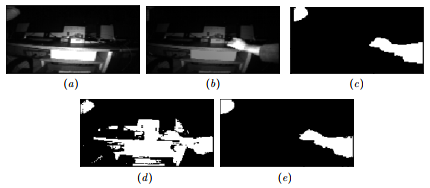

Figure 1: Parts (a) and (b) above show what is sudden large change in pixel values. Part
(a) was taken under a strong light environment, while part (b) was taken under a weak
light environment. Although they are in the same scene, there is a huge difference in
pixel values. Here, the performances of using traditional foreground detection and the new
algorithm are compared. (a) Intensity map acts as a background. (b) Intensity map acts
as a contrast. (c) Foreground (actual difference): the region in white indicates foreground
while the region in black represents background (d) The output of the traditional foreground
detection algorithms. (e) The output of the new algorithm.

# Parameters

In [5]:
IMG_WIDTH = 160
IMG_HEIGHT = 120
BUFFER_SIZE = 512
BATCH_SIZE = 16
TRAIN_EPOCH = 80

MAIN_DIR = "E:\\Github\\ForegroundDetectionToF\\"
DS_PATH = MAIN_DIR + 'Datasets\\'
IMGS_ZIP_PATH = DS_PATH + "Datasets.zip"
TRAIN_DS_XY_PATH = DS_PATH + 'train_ds_xy.npy'
TRAIN_DS_RAW_PATH = DS_PATH + 'train_ds_raw.npy'

VALID_DS_XY_PATH = DS_PATH + 'valid_ds_xy.npy'
VALID_DS_RAW_PATH = DS_PATH + 'valid_ds_raw.npy'

TEST_DS_XY_PATH = DS_PATH + 'test_ds_xy.npy'
TEST_DS_RAW_PATH = DS_PATH + 'test_ds_raw.npy'

MODEL_PATH = MAIN_DIR + 'Models\\'
MODEL_H5_PATH = MODEL_PATH + 'ForegroundDetectionToF.h5'
MODEL_PD_PATH = MODEL_PATH + 'ForegroundDetectionToF.pd'
MODEL_TFLITE_PATH = MODEL_PATH + 'ForegroundDetectionToF.tflite'

# Visualize Image && Lines

In [6]:
import matplotlib.pyplot as plt
import cv2
import math

def imgs_visualization(imgs, title=None, dpi=450):  
    plt.rcParams['savefig.dpi'] = dpi
    plt.rcParams['figure.dpi'] = dpi
    for i in range(len(imgs)):
        plt.subplot(math.ceil(len(imgs) / 8), min(len(imgs), 8), i + 1)
        plt.axis('off')
        if title is not None:
            plt.title(str(title[i]))
        plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2BGR))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    
def line_visualization(x_axis, y_axis, xlabel=None, ylabel=None, title=None, dpi=450):  
    plt.rcParams['savefig.dpi'] = dpi
    plt.rcParams['figure.dpi'] = dpi
    if title is not None:
        plt.title(str(title))
    if xlabel is not None:
        plt.xlabel(str(xlabel))
    if ylabel is not None:
        plt.ylabel(str(ylabel))
    plt.plot(x_axis, y_axis)
    plt.show()
    
def lines_visualization(xs_axis, ys_axis, lines_label=None, xlabel=None, ylabel=None, title=None, dpi=450):  
    plt.rcParams['savefig.dpi'] = dpi
    plt.rcParams['figure.dpi'] = dpi
    if title is not None:
        plt.title(str(title))
    if xlabel is not None:
        plt.xlabel(str(xlabel))
    if ylabel is not None:
        plt.ylabel(str(ylabel))
    for i in range(len(xs_axis)):
        plt.plot(xs_axis[i], ys_axis[i], label = (None if (lines_label is None) else lines_label[i]))
    plt.legend()
    plt.show()


# Generator Slice

In [7]:
def iter_slice(target, max_steps):
    for idx, item in enumerate(iter(target)):
        if(idx < max_steps):
            yield item
        else:
            break

# Convert raw ds to numpy format

100%|██████████| 560/560 [00:03<00:00, 161.04it/s]


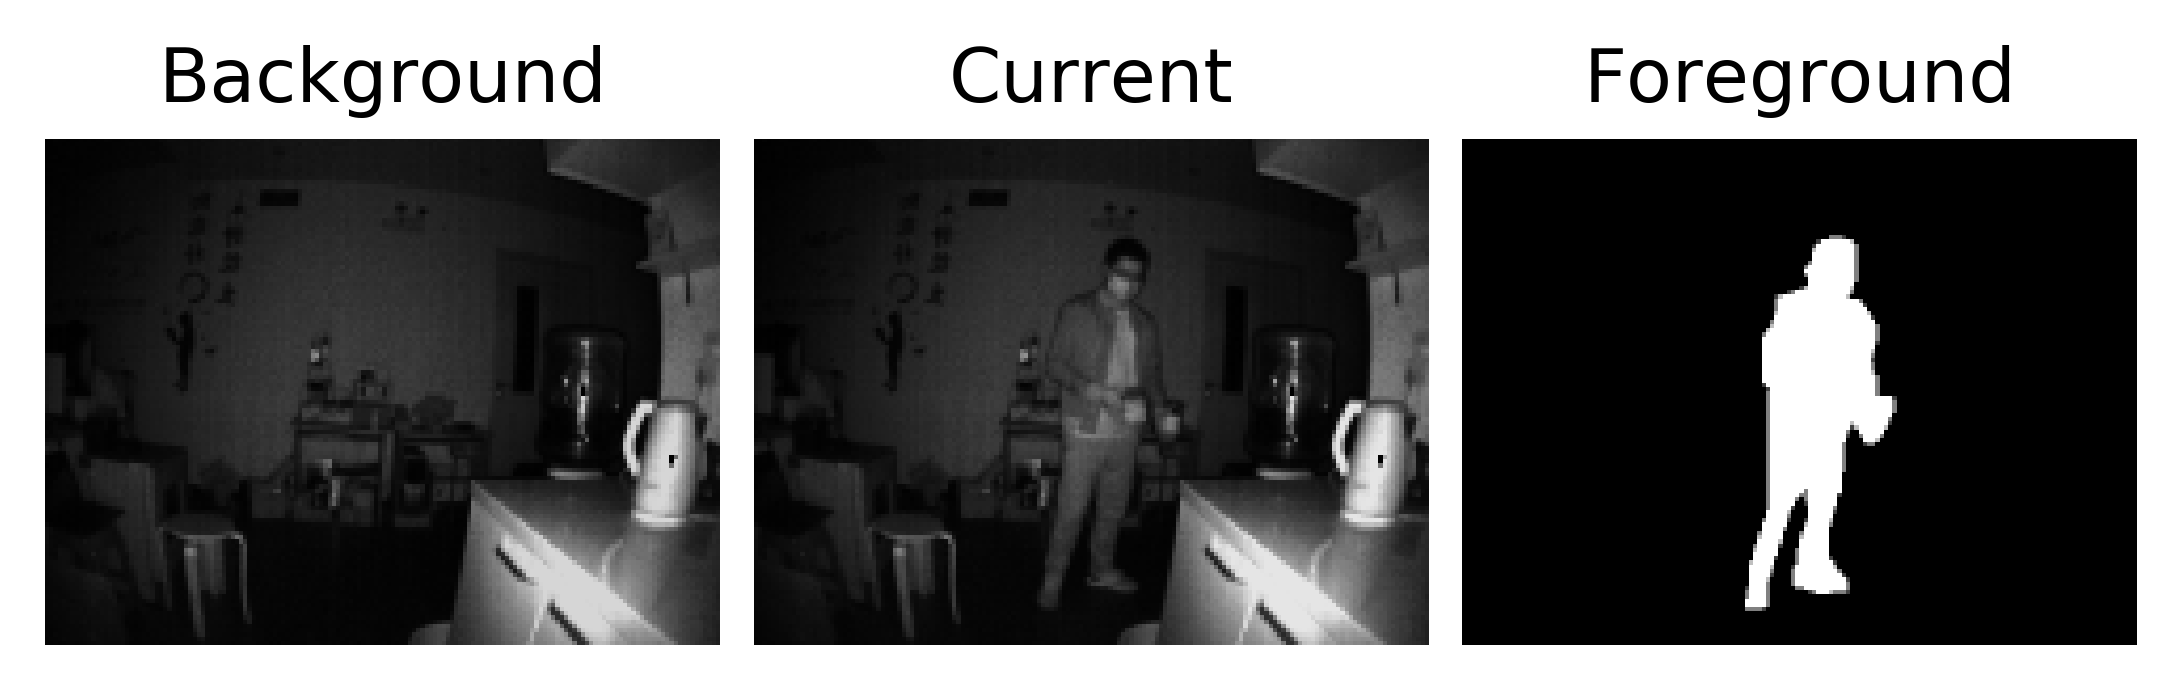

In [8]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import zipfile
import random

class zip_reader():
    def __init__(self, path):
        self.zip_handler = zipfile.ZipFile(path, mode='r')
    
    def list_files(self):
        return self.zip_handler.namelist()
        
    def parse_file(self, filename):
        with self.zip_handler.open(filename, mode='r') as image_file:
            img = image_file.read()
            img = np.asarray(bytearray(img), dtype='uint8')
            img = cv2.imdecode(img, cv2.IMREAD_UNCHANGED)
            return img
    
    def close(self):
        self.zip_handler.close()
        self.zip_handler = None

class dir_reader():
    def __init__(self, path):
        self.zip_handler = [os.path.join(dirname, filename) for dirname, _, filenames in os.walk(path) for filename in filenames]
    
    def list_files(self):
        return self.zip_handler
        
    def parse_file(self, filename):
        return cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    
    def close(self):
        self.zip_handler = None
        
def preprocess_ds():
    reader = zip_reader(IMGS_ZIP_PATH)
    #reader = dir_reader(IMGS_ZIP_PATH.split(".")[0])
    
    file_list = [name for name in reader.list_files() if (name.endswith(".png") or name.endswith(".jpg"))]
    random.shuffle(file_list)
    
    xy = np.zeros((len(file_list), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
    for idx, name in enumerate(tqdm(file_list)):
        img = reader.parse_file(name)
        img = cv2.resize(img, (IMG_WIDTH * 3, IMG_HEIGHT), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        xy[idx] = np.stack(np.split(img, 3, axis = 1), axis = -1)

    imgs_visualization((xy[0][:,:,0], xy[0][:,:,1], xy[0][:,:,2]), ["Background", "Current", "Foreground"])

    np.save(TRAIN_DS_XY_PATH, xy[int(0 * xy.shape[0]) : int(0.8 * xy.shape[0]), :, :, :])
    np.save(VALID_DS_XY_PATH, xy[int(0.8 * xy.shape[0]): int(0.9 * xy.shape[0]), :, :, :])
    np.save(TEST_DS_XY_PATH, xy[int(0.9 * xy.shape[0]) : int(1.1 * xy.shape[0]), :, :, :])

    np.save(TRAIN_DS_RAW_PATH, file_list[int(0 * xy.shape[0]) : int(0.8 * xy.shape[0])])
    np.save(VALID_DS_RAW_PATH, file_list[int(0.8 * xy.shape[0]): int(0.9 * xy.shape[0])])
    np.save(TEST_DS_RAW_PATH, file_list[int(0.9 * xy.shape[0]) : int(1.1 * xy.shape[0])])
    
    reader.close()
    
    
preprocess_ds()

# Load Tensorflow

In [9]:
import tensorflow as tf

print (tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.3.1
Default GPU Device: /device:GPU:0


# Online Datasets Augmentation

(1) Apply 2d gaussian noise on background && current (Simulate multipath distortions && dynamic integration time)

(2) Apply affine transformation on foreground && current (Simulate foreground located in different locations)

(3) Apply affine transformation on background && current (Regular augmentation)

(4) Apply Moasic && Cutmix on background && current (Regular augmentation)

In [10]:
import tensorflow.keras.backend as B
import math
from functools import reduce

# 2d gaussian noise
@tf.function
def aug_2d_gauss(img_batch):
    # img_batch (Batch Size, Img_h, Img_w, Img_c)
    @tf.function
    def random_gauss(img, d_l = 4.0, d_u = 7.0, sigma_l = 1., sigma_u = 2.0, mu_l = 0.0, mu_u = 0.0):
        img_h, img_w = img.shape[0], img.shape[1]
        meshgrid_x, meshgrid_y = tf.meshgrid(
            tf.linspace(-tf.random.uniform([], d_l, d_u), tf.random.uniform([], d_l, d_u), img_w), 
            tf.linspace(-tf.random.uniform([], d_l, d_u), tf.random.uniform([], d_l, d_u), img_h)) # (Img_h, Img_w)
        sigma, mu = tf.random.uniform([1, 1], sigma_l, sigma_u), tf.random.uniform([1, 1], mu_l, mu_u) # (1, 1)
        gauss = tf.math.exp(-((tf.math.sqrt(meshgrid_x**2 + meshgrid_y**2) - mu)**2 / ( 2.0 * sigma**2 ))) # (Img_h, Img_w)
        return gauss
    @tf.function
    def random_roll(img):
        img_h, img_w = img.shape[0], img.shape[1]
        img = tf.roll(img, tf.random.uniform([], -img_h, img_h, dtype=tf.int32), axis = 0)
        img = tf.roll(img, tf.random.uniform([], -img_w, img_w, dtype=tf.int32), axis = 1)
        return img
        
    batch_size, img_h, img_w, img_c = tf.shape(img_batch)[0], img_batch.shape[1], img_batch.shape[2], img_batch.shape[3]
    # Add 2d gaussian noise
    gauss_cnt = 15
    # (gauss cnt * Batch Size * Img_c, Img_h, Img_w)
    gauss_batch = tf.zeros((gauss_cnt * batch_size * img_c, img_h, img_w))
    gauss_batch = tf.map_fn(lambda t: random_gauss(t), elems=gauss_batch)
    gauss_batch = tf.map_fn(lambda t: random_roll(t), elems=gauss_batch)
    gauss_batch = tf.reshape(gauss_batch, (gauss_cnt, batch_size, img_c, img_h, img_w))
    gauss_sum = tf.math.reduce_sum(gauss_batch, axis=0) # (Batch Size, Img_c, Img_h, Img_w)
    gauss_sum = tf.transpose(gauss_sum, [0, 2, 3, 1]) # (Batch Size, Img_h, Img_w, Img_c)
    gauss_sum = gauss_sum / tf.math.reduce_max(gauss_sum, axis=0, keepdims=True)
    img_batch = img_batch * 0.6 + img_batch * gauss_sum * 0.4
    # scale
    img_batch = img_batch * tf.random.uniform([batch_size, 1, 1, img_c], 0.5, 1.0)
    return img_batch

# Cutmix
@tf.function
def aug_cutmix(img_batch):
    batch_size, img_h, img_w = tf.shape(img_batch)[0], img_batch.shape[1], img_batch.shape[2]
    # CHOOSE RANDOM LOCATION
    cut_xs = tf.cast(tf.random.uniform([batch_size], 0, tf.cast(img_w, tf.float32)), tf.int32) # (Batch Size)
    cut_ys = tf.cast(tf.random.uniform([batch_size], 0, tf.cast(img_h, tf.float32)), tf.int32) # (Batch Size)
    cut_ratios = tf.math.sqrt(1 - tf.random.uniform([batch_size], 0, 1)) # cut ratio
    cut_ws = tf.cast(tf.cast(img_w, tf.float32) * cut_ratios, tf.int32)
    cut_hs = tf.cast(tf.cast(img_h, tf.float32) * cut_ratios, tf.int32)
    yas = tf.math.maximum(0, cut_ys - cut_hs // 2)      # (Batch Size)
    ybs = tf.math.minimum(img_h, cut_ys + cut_hs // 2)  # (Batch Size)
    xas = tf.math.maximum(0, cut_xs - cut_ws // 2)      # (Batch Size)
    xbs = tf.math.minimum(img_w, cut_xs + cut_ws // 2)  # (Batch Size)
    # CHOOSE RANDOM IMAGE TO CUTMIX WITH
    index = tf.random.shuffle(tf.range(batch_size, dtype=tf.int32))
    x1, x2 = img_batch, tf.gather(img_batch, index)
    
    X, Y = tf.meshgrid(tf.range(img_w), tf.range(img_h))
    X = tf.expand_dims(X, axis=0) # (1, img_h, img_w)
    Y = tf.expand_dims(Y, axis=0) # (1, img_h, img_w)
    img_weight = tf.math.logical_and(tf.math.logical_and(tf.reshape(xas, (-1, 1, 1)) <= X, X <= tf.reshape(xbs, (-1, 1, 1)) ), 
                                     tf.math.logical_and(tf.reshape(yas, (-1, 1, 1)) <= Y, Y <= tf.reshape(ybs, (-1, 1, 1)) ))
    img_weight = tf.expand_dims(img_weight, axis=-1) # (Batch Size, img_h, img_w, 1)
    img_batch = tf.where(img_weight, x2, x1)
    return img_batch

# Mosaic
@tf.function
def aug_mosaic(img_batch):
    @tf.function
    def random_mosaic(img):
        # (Img_h, Img_w, Img_c, 4)
        img_h, img_w, img_c = img.shape[0], img.shape[1], img.shape[2]
        x_center = tf.cast(tf.random.uniform([], 0.2, 0.8) * img_w, tf.int32) # (Batch Size)
        y_center = tf.cast(tf.random.uniform([], 0.2, 0.8) * img_h, tf.int32) # (Batch Size)
        img = tf.concat([tf.concat([img[:y_center, :x_center, :, 0], img[:y_center, x_center:, :, 1]], axis=1),
                        tf.concat([img[y_center:, :x_center, :, 2], img[y_center:, x_center:, :, 3]], axis=1)], axis=0)
        img = tf.reshape(img, (img_h, img_w, img_c))
        return img
            
    batch_size, img_h, img_w = tf.shape(img_batch)[0], img_batch.shape[1], img_batch.shape[2]
    
    # (Batch Size, Img_h, Img_w, Img_c, 4)
    img_batch_list = tf.stack([tf.random.shuffle(img_batch), tf.random.shuffle(img_batch), 
                               tf.random.shuffle(img_batch), tf.random.shuffle(img_batch)], axis=-1)
    img_batch = tf.map_fn(lambda t: random_mosaic(t), elems=img_batch_list)
    return img_batch
        
    
# Affine transformation
@tf.function
def aug_affine(img_batch, rotation=2, shear=2, zoom=[1.0, 1.0], shift=[-16, 16], flip=3):
    # img_batch (Batch Size, Img_h, Img_w, Img_c)
    batch_shape, batch_size, img_h, img_w = tf.shape(img_batch), tf.shape(img_batch)[0], img_batch.shape[1], img_batch.shape[2]
    # returns 3x3 transformmatrix which transforms indicies
    one = tf.ones([batch_size, 1], dtype='float32') # (Batch Size, 1)
    zero = tf.zeros([batch_size, 1], dtype='float32') # (Batch Size, 1)
    m_list = []
    if rotation != 0:
        rotation = math.pi * tf.random.uniform(shape=[batch_size, 1], minval=-rotation, maxval=rotation) / 180. # (Batch Size, 1)
        c1 = tf.math.cos(rotation) # (Batch Size, 1)
        s1 = tf.math.sin(rotation) # (Batch Size, 1)
        rotation_matrix = tf.concat([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=-1) # (Batch Size, 9)
        rotation_matrix = tf.reshape(rotation_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        m_list.append(rotation_matrix)
    if shear != 0:
        shear = math.pi * tf.random.uniform(shape=[batch_size, 1], minval=-shear, maxval=shear) / 180.       # (Batch Size, 1)
        c2 = tf.math.cos(shear) # (Batch Size, 1)
        s2 = tf.math.sin(shear) # (Batch Size, 1)
        shear_matrix = tf.concat([one, s2, zero, zero, c2, zero, zero, zero, one], axis=-1) # (Batch Size, 9)
        shear_matrix = tf.reshape(shear_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        m_list.append(shear_matrix)
    if zoom[0] != 1 or zoom[1] != 1:
        width_zoom = tf.random.uniform(shape=[batch_size, 1], minval=zoom[0], maxval=zoom[1]) # (Batch Size, 1)
        height_zoom = tf.random.uniform(shape=[batch_size, 1], minval=zoom[0], maxval=zoom[1]) # (Batch Size, 1)
        zoom_matrix = tf.concat([one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one], axis=-1) # (Batch Size, 9)
        zoom_matrix = tf.reshape(zoom_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        m_list.append(zoom_matrix)
    if shift[0] != 0 or shift[1] != 0:
        height_shift = tf.random.uniform(shape=[batch_size, 1], minval=shift[0], maxval=shift[1]) # (Batch Size, 1)
        width_shift = tf.random.uniform(shape=[batch_size, 1], minval=shift[0], maxval=shift[1]) # (Batch Size, 1)
        shift_matrix = tf.concat([one, zero, height_shift, zero, one, width_shift, zero, zero, one], axis=-1)
        shift_matrix = tf.reshape(shift_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        m_list.append(shift_matrix)
    if flip != 0:
        # 1: left_right 2: up_down 3: both
        flip_y = tf.where(tf.random.uniform(shape=[batch_size, 1]) >= (0.5 if (flip == 1 or flip == 3) else 0), 1., -1.)
        flip_x = tf.where(tf.random.uniform(shape=[batch_size, 1]) >= (0.5 if (flip == 2 or flip == 3) else 0), 1., -1.)
        flip_matrix = tf.concat([flip_x, zero, zero, zero, flip_y, zero, zero, zero, one], axis=-1)
        flip_matrix = tf.reshape(flip_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        m_list.append(flip_matrix)
    if len(m_list) > 0:
        # Merge matrix
        m_list = tf.unstack(tf.random.shuffle(tf.stack(m_list, axis=0)), axis=0) # List of (Batch Size, 3, 3)
        m = reduce((lambda x, y: B.batch_dot(x, y)), m_list)
        
        # List destination pxiel indices
        x, y = tf.meshgrid(tf.range(img_w//2, -img_w//2, -1), tf.range(-img_h//2, img_h//2, 1)) # (IMG_H, IMG_W)
        x, y = tf.reshape(x, [-1]), tf.reshape(y, [-1])
        z = tf.ones([img_h * img_w], tf.int32) # (IMG_H * IMG_W)
        idx = tf.stack([x, y, z])              # (3, IMG_H * IMG_W)
        idx = tf.repeat(tf.expand_dims(idx, axis=0), batch_size, axis=0)  # (Batch Size, 3, IMG_H * IMG_W)

        # Rotate destination pixels onto origin pixels
        idx = tf.cast(B.batch_dot(m, tf.cast(idx, tf.float32)), tf.int32) # (Batch Size, 3, IMG_H * IMG_W)
        x_idx, y_idx = idx[:,0,:], idx[:,1,:]
        x_idx_valid = tf.math.logical_and(-img_w//2 + img_w%2 + 1 <= x_idx, x_idx <= img_w//2) # (Batch Size, IMG_H * IMG_W)
        y_idx_valid = tf.math.logical_and(-img_h//2 + img_h%2 + 1 <= y_idx, y_idx <= img_h//2) # (Batch Size, IMG_H * IMG_W)
        idx_valid = tf.math.logical_and(x_idx_valid, y_idx_valid) # # (Batch Size, IMG_H * IMG_W)
        x_idx = tf.where(x_idx_valid, x_idx, 0)
        y_idx = tf.where(y_idx_valid, y_idx, 0)
        
        # Find origin pixel values
        idx = tf.stack([img_h//2-1+y_idx, img_w//2-x_idx],axis=-1) # (Batch Size, IMG_H * IMG_W, 2)
        img_batch = tf.gather_nd(img_batch, idx, batch_dims=1) # (Batch Size, IMG_H * IMG_W, 3)
        img_batch = tf.where(tf.expand_dims(idx_valid, axis=-1), img_batch, 0)
        img_batch = tf.reshape(img_batch, batch_shape)
    return img_batch
    
@tf.function
def ds_augumentation(img_bg, img_curr, img_fg):
    # img_bg (Batch Size, Img_h, Img_w)
    # img_curr (Batch Size, Img_h, Img_w)
    # img_fg (Batch Size, Img_h, Img_w)
    
    @tf.function
    def ms_func(func, data):
        return tf.unstack(func(tf.stack(data, axis=-1)), axis=-1)
    
    # Apply Affine Transformation on foreground
    img_curr, img_fg = ms_func(aug_affine, [img_curr, img_fg])
    img_curr = tf.where(img_fg > 0, img_curr, img_bg)
    
    # Apply Affine Transformation && Cutmix && 2D Gaussian Noise on all
    img_bg, img_curr, img_fg = ms_func(aug_affine, [img_bg, img_curr, img_fg])
    img_bg, img_curr, img_fg = ms_func(aug_cutmix, [img_bg, img_curr, img_fg])
    # img_bg, img_curr, img_fg = ms_func(aug_mosaic, [img_bg, img_curr, img_fg])
    img_bg, img_curr = ms_func(aug_2d_gauss, [img_bg, img_curr])
    
    # Randomly Shuffle img_bg && img_curr
    shuffle_cond = tf.random.uniform(shape=[tf.shape(img_bg)[0], 1, 1]) >= 0.5
    img_bg, img_curr = tf.where(shuffle_cond, img_bg, img_curr), tf.where(shuffle_cond, img_curr, img_bg)

    return img_bg, img_curr, img_fg

@tf.function
def ds_format(img_bg, img_curr, img_fg):
    return tf.stack([img_bg, img_curr], axis=-1), tf.stack([img_fg], axis=-1)

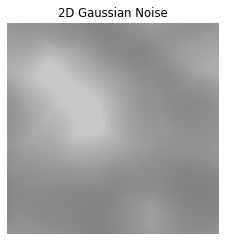

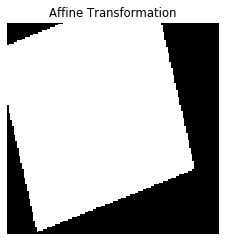

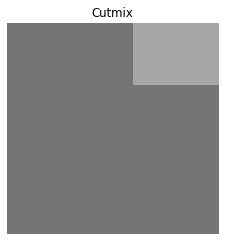

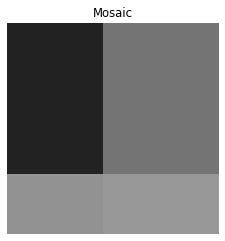

In [11]:
# Test 2D Gaussian
img_batch = tf.ones((64, 128, 128, 1))
img_batch = aug_2d_gauss(img_batch)
imgs_visualization([img_batch.numpy()[0,:,:,0]], ["2D Gaussian Noise"], dpi=70)

# Test Affine Transformation
img_batch = tf.ones((64, 128, 128, 3))
img_batch = aug_affine(img_batch, rotation=25, shear=10, zoom=[0.7, 0.9], shift=[-16,16], flip=3)
imgs_visualization([img_batch.numpy()[0,:,:,0]], ["Affine Transformation"], dpi=70)

# Test Cutmix
img_batch = tf.ones((64, 128, 128, 3)) * tf.random.uniform(shape=[64, 1, 1, 1])
img_batch = aug_cutmix(img_batch)
imgs_visualization([img_batch.numpy()[0,:,:,0]], ["Cutmix"], dpi=70)
del img_batch

# Test Mosaic
img_batch = tf.ones((64, 128, 128, 3)) * tf.random.uniform(shape=[64, 1, 1, 1])
img_batch = aug_mosaic(img_batch)
imgs_visualization([img_batch.numpy()[0,:,:,0]], ["Mosaic"], dpi=70)
del img_batch

# Load Datasets

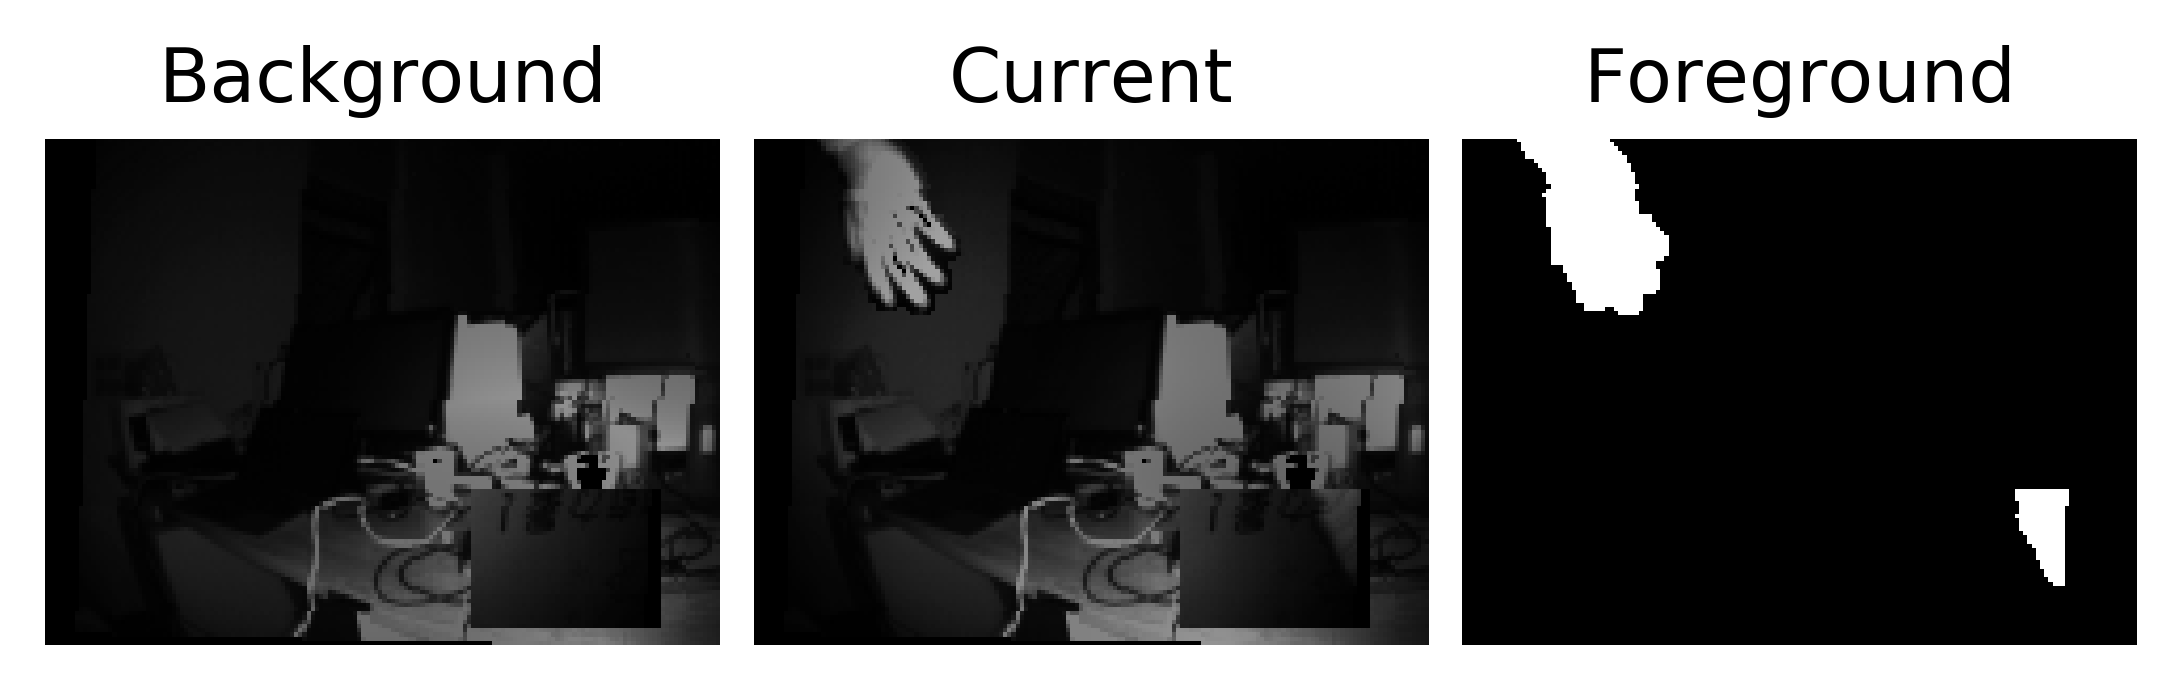

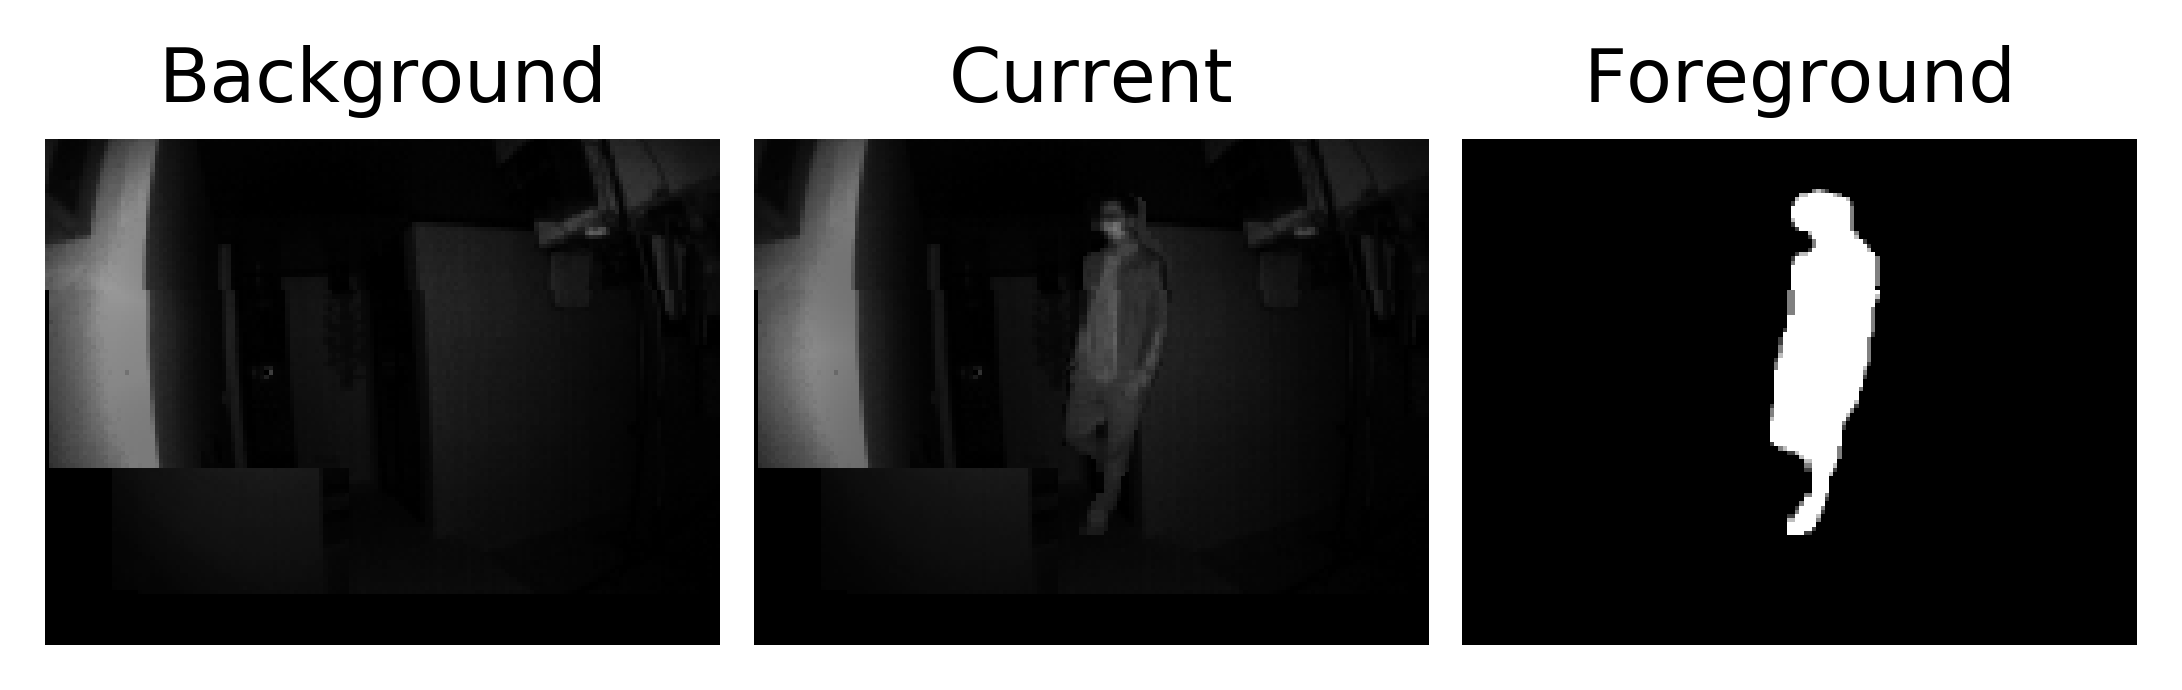

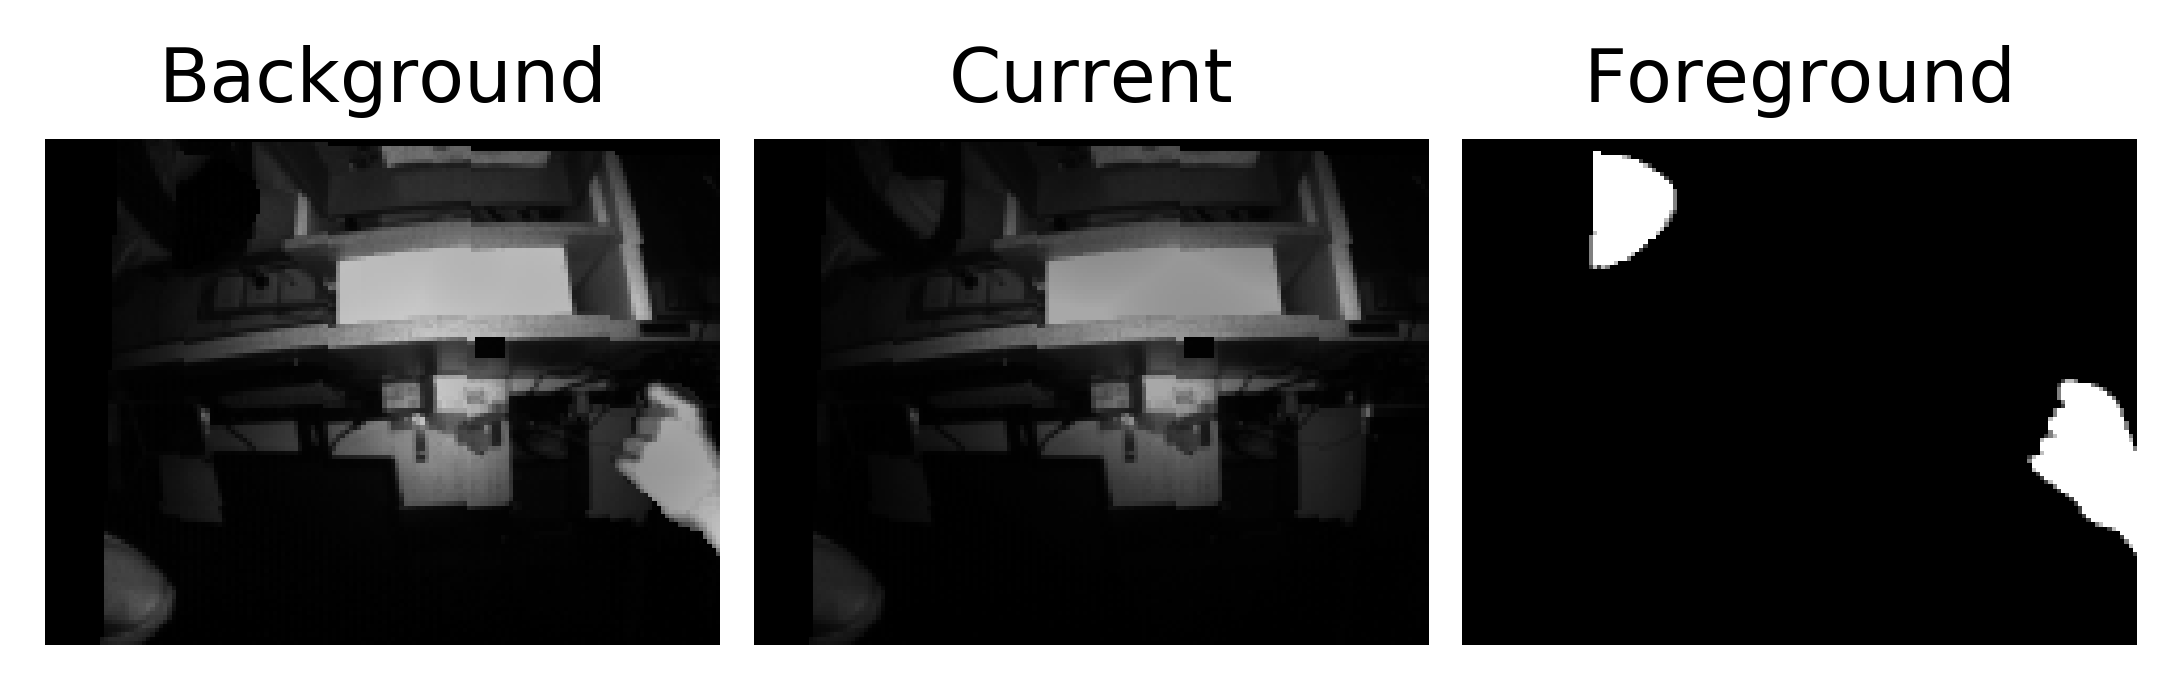

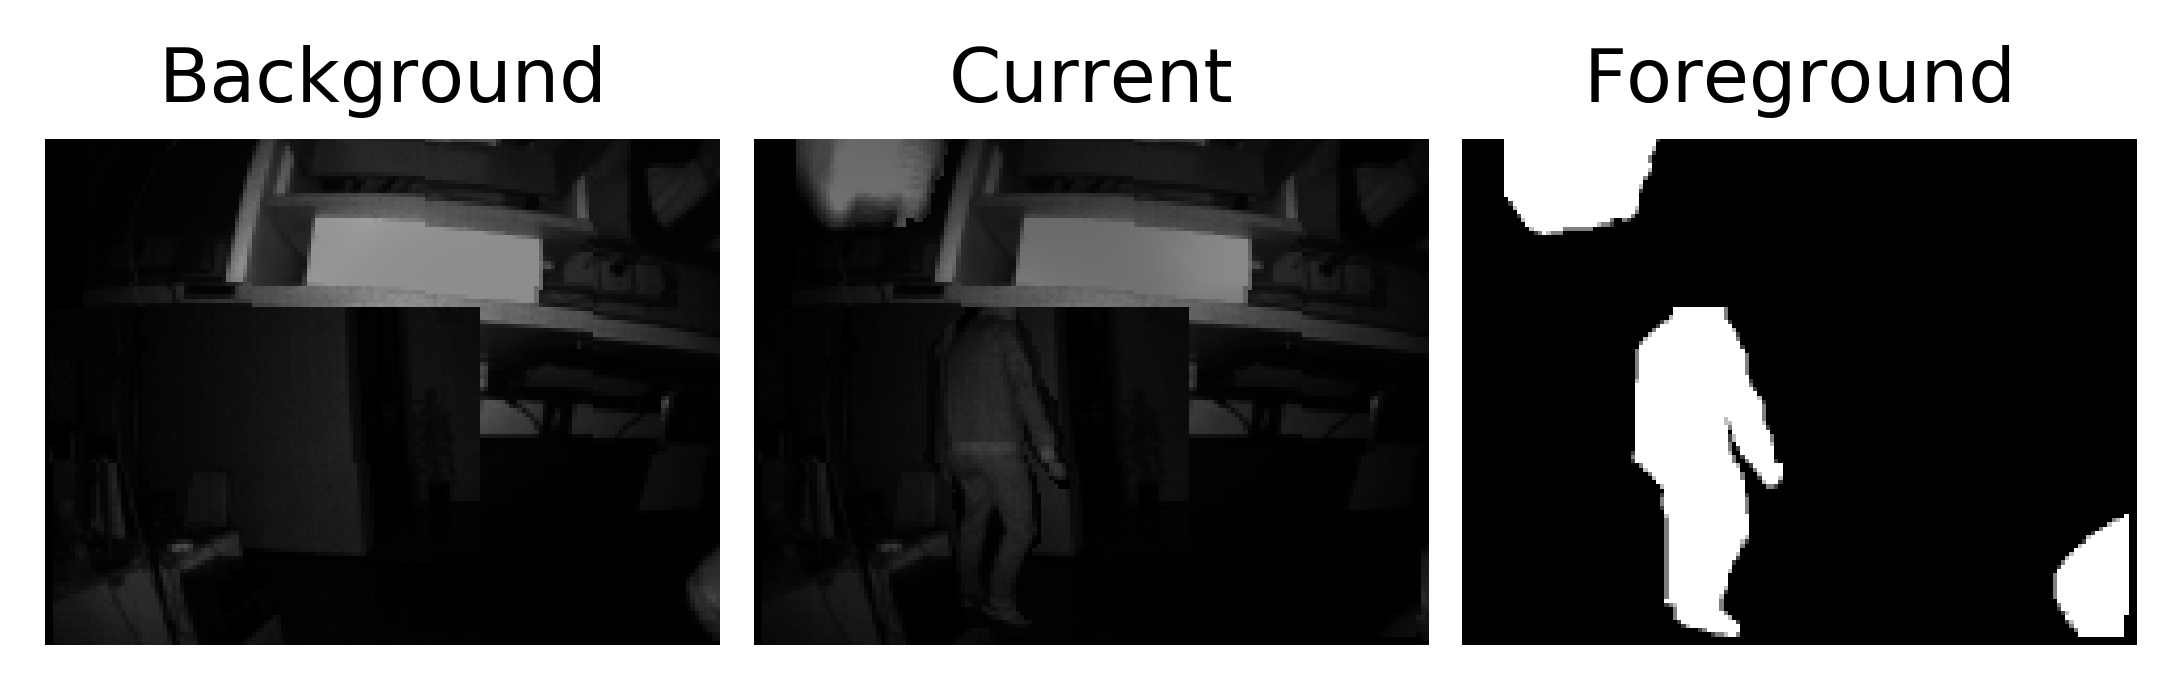

In [13]:
def ds_tensor(ds_path, aug_en = False, shuffle_en=False):
    imgs_np = np.load(ds_path)
    img_bg = (imgs_np[:,:,:,0] / 255.).astype(np.float32)
    img_curr = (imgs_np[:,:,:,1] / 255.).astype(np.float32)
    img_fg = (imgs_np[:,:,:,2] / 255.).astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((img_bg, img_curr, img_fg)).cache()
    if shuffle_en:
        ds =  ds.shuffle(BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    if aug_en:
        ds = ds.map(ds_augumentation)
    ds = ds.map(ds_format)
    return ds, math.ceil(imgs_np.shape[0] / BATCH_SIZE)

train_ds_format, train_ds_steps  = ds_tensor(TRAIN_DS_XY_PATH, aug_en=True, shuffle_en=True)
valid_ds_format, valid_ds_steps  = ds_tensor(VALID_DS_XY_PATH, aug_en=False, shuffle_en=False)
test_ds_format, test_ds_steps  = ds_tensor(TEST_DS_XY_PATH, aug_en=False, shuffle_en=False)

for x, y in iter_slice(train_ds_format, 4):
    x, y = x.numpy(), y.numpy()
    imgs_visualization((x[0,:,:,0], x[0,:,:,1], y[0,:,:,0]), ["Background", "Current", "Foreground"])

# Evaluation Metric

In [14]:
def metric_mIOU(y_true, y_pred, epsilon=1e-7):
    # IoU = true_positive / (true_positive + false_positive + false_negative)
    y_pred = tf.cast(tf.reshape(y_pred >= 0.5, [tf.shape(y_pred)[0], -1]), tf.int32)
    y_true = tf.cast(tf.reshape(y_true >= 0.5, [tf.shape(y_true)[0], -1]), tf.int32)
    target = 1
    # (Batch Size, IMG_H * IMG_W)
    tp = tf.math.reduce_sum(tf.cast(tf.math.logical_and(y_pred == target, y_true == target), tf.float32), 1)
    fp = tf.math.reduce_sum(tf.cast(tf.math.logical_and(y_pred == target, y_true != target), tf.float32), 1)
    fn = tf.math.reduce_sum(tf.cast(tf.math.logical_and(y_pred != target, y_true == target), tf.float32), 1)
    # prevent 0
    return tf.math.reduce_mean(tf.math.maximum(tp, epsilon) / tf.math.maximum(tp + fp + fn, epsilon))

# Learning Rate Control

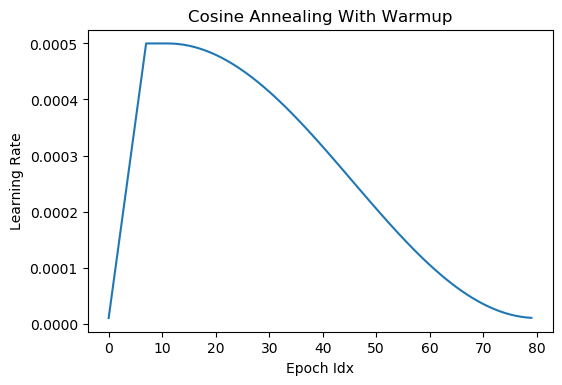

In [15]:
# 余弦退火 (提点 Trick)
def cosine_annealing_with_warmup(epoch_idx):
    a_min, a_max = 1e-5, 5e-4
    warmup_epochs, stagnate_epochs, cos_annealing_epochs = [int(TRAIN_EPOCH * p) for p in [0.1, 0.05, 0.85]]
    epoch_idx = epoch_idx % (warmup_epochs + stagnate_epochs + cos_annealing_epochs)
    if(epoch_idx < warmup_epochs):
        return a_min + (a_max - a_min) / (warmup_epochs - 1) * epoch_idx
    else:
        epoch_idx -= warmup_epochs
    if(epoch_idx < stagnate_epochs):
        return a_max
    else:
        epoch_idx -= stagnate_epochs
    return a_min + 0.5 * (a_max - a_min) * (1 + math.cos((epoch_idx + 1) / (cos_annealing_epochs + 1) * math.pi))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(cosine_annealing_with_warmup, verbose=1)

# Visualize Learning Rate
x_axis = np.arange(TRAIN_EPOCH)
y_axis = [cosine_annealing_with_warmup(x) for x in x_axis]
line_visualization(x_axis, y_axis, xlabel="Epoch Idx", ylabel="Learning Rate", title="Cosine Annealing With Warmup", dpi=100)
del x_axis, y_axis

# Model Checkpoint

In [16]:
from tensorflow.keras.callbacks import *

cp_schedule = ModelCheckpoint(filepath=MODEL_H5_PATH, monitor='val_metric_mIOU', verbose=1, save_weights_only=True, save_best_only=True, mode='max')

# Model Loss

In [17]:
def focal_loss(y_true, y_pred, alpha = 0.5, epsilon = 1e-7, gamma=2.0):
    # y_true (batch size, IMG_HEIGHT, IMG_WIDTH, 1)
    # y_pred (batch size, IMG_HEIGHT, IMG_WIDTH, 1)

    y_diff = tf.math.abs(y_true - y_pred)
    weights = ((alpha) * y_true + (1 - alpha) * (1. - y_true)) * tf.pow(y_diff, gamma)
    loss = weights * (- tf.math.log(tf.math.maximum(1.0 - y_diff, epsilon)))
    return loss

# print(focal_loss(tf.constant([[0.0, 1.0], [0.0, 1.0]]), tf.constant([[0.4, 0.6], [0.4, 0.6]])))

# Build Model

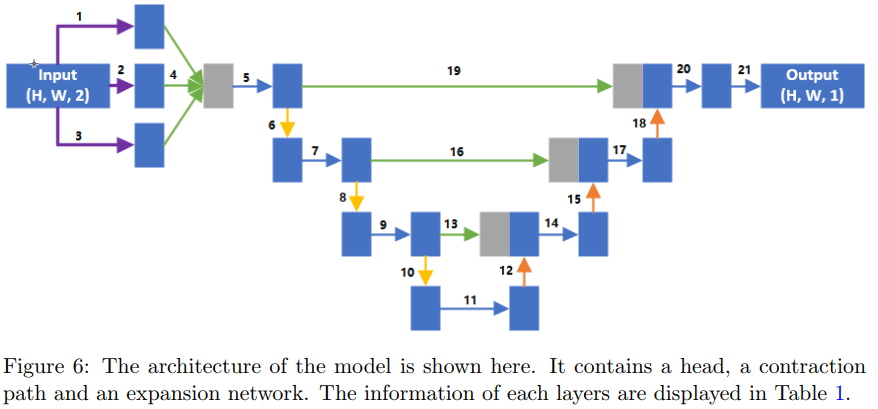

In [40]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras import *
from os import path


# Conv + BN + Activation
def basic_conv(filters=16, k_size=1, stride=1, padding='same', dilation=1, bn=True, act=tf.nn.relu, name=''):
    def call(x):
        x = layers.Conv2D(filters, k_size, stride, padding=padding, dilation_rate=dilation, use_bias=False, name=name+"_conv")(x)
        x = layers.BatchNormalization(name=name+"_bn")(x) if bn else x
        x = layers.Activation(act, name=name+"_act")(x) if act else x
        return x
    return call

# Mult-Dilation Conv
def mdilation_conv(name=''):
    def call(x):
        inter_planes = 16
        x0, x1, x2 = x, x, x
        for layer in [basic_conv(inter_planes, k_size=3, dilation=1, bn=False, act=None, name=name+'_branch0')]:
            x0 = layer(x0)
        for layer in [basic_conv(inter_planes, k_size=3, dilation=3, bn=False, act=None, name=name+'_branch1')]:
            x1 = layer(x1)
        for layer in [basic_conv(inter_planes, k_size=3, dilation=5, bn=False, act=None, name=name+'_branch2')]:
            x2 = layer(x2)
        x = layers.Concatenate(axis=-1, name=name+'_concat')([x0, x1, x2])
        x = basic_conv(inter_planes * 2, k_size=1, bn=False, act=None, name=name+'_linear')(x)
        return x
    return call

# A simplified U-Net
def simple_unet(layers_cnt = 3, name=''):
    def call(x):
        down_path = []
        prev_input = x
        for i in range(layers_cnt):
            down = basic_conv(16 * (i + 1), 3, name=name+'_dconv_'+str(i))(prev_input)
            down_path.append(down)
            down = layers.MaxPooling2D(pool_size=(2, 2), name=name+'_dpool_'+str(i))(down)
            prev_input = down

        for i in range(layers_cnt):
            up = basic_conv(16 * (layers_cnt - i), 3, name=name+'_uconv_'+str(i))(prev_input)
            up = layers.UpSampling2D(size = (2,2), name=name+'_usample_'+str(i))(up)
            up = layers.Concatenate(axis = 3, name=name+'_concat_'+str(i))([down_path[layers_cnt - i - 1], up])
            prev_input = up
        return prev_input
    return call
 
def load_model(model):
    if model is None:
        inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 2), name="Input")
        output = mdilation_conv(name='MDConv')(inputs)
        output = simple_unet(layers_cnt = 3, name='S-Unet')(output)
        output = basic_conv(16, 1, name='F1Conv')(output)
        output = basic_conv(1, 3, name = "F2Conv", bn=False, act=tf.nn.sigmoid)(output)
        model = tf.keras.Model(inputs=inputs, outputs=output, name='Model')
    #model.summary()
    # Load pretrained model
    if path.exists(MODEL_H5_PATH):
        model.load_weights(MODEL_H5_PATH)
        print("Model Loaded !")
    return model

def compile_model(model):
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics = [metric_mIOU])
    return model

model_compiled = load_model(None)
model_compiled = compile_model(model_compiled)
model_compiled.summary()

Model Loaded !
Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 120, 160, 2) 0                                            
__________________________________________________________________________________________________
MDConv_branch0_conv (Conv2D)    (None, 120, 160, 16) 288         Input[0][0]                      
__________________________________________________________________________________________________
MDConv_branch1_conv (Conv2D)    (None, 120, 160, 16) 288         Input[0][0]                      
__________________________________________________________________________________________________
MDConv_branch2_conv (Conv2D)    (None, 120, 160, 16) 288         Input[0][0]                      
_______________________________________________________________________________

# Training

In [ ]:
training_callback=[lr_schedule, cp_schedule]

training_history = model_compiled.fit(train_ds_format, 
                                      initial_epoch = 30,
                                      epochs=TRAIN_EPOCH, 
                                      verbose = 1, shuffle = 1, 
                                      validation_data=valid_ds_format, 
                                      callbacks=training_callback)

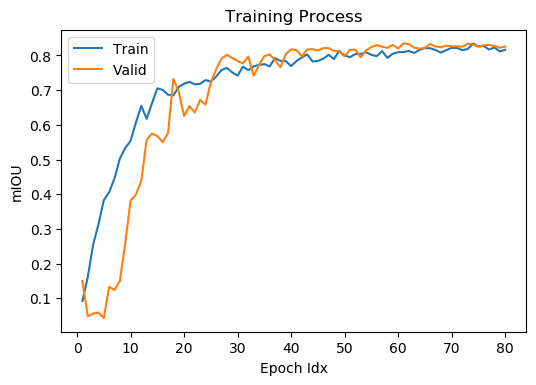

In [72]:
# Visualize Training Process

epoch_idxs = np.arange(len(training_history.history["loss"])) + 1
lines_visualization((epoch_idxs, epoch_idxs), 
                    (training_history.history["metric_mIOU"], training_history.history["val_metric_mIOU"]), 
                    lines_label=("Train", "Valid"), 
                    xlabel="Epoch Idx", ylabel="mIOU", title="Training Process", dpi=100)
del epoch_idxs

In [39]:
# Load best model

model_compiled = load_model(model_compiled)

Model Loaded !


# Test

4/4 [==============================] - 0s 66ms/step - loss: 0.0492 - metric_mIOU: 0.8337


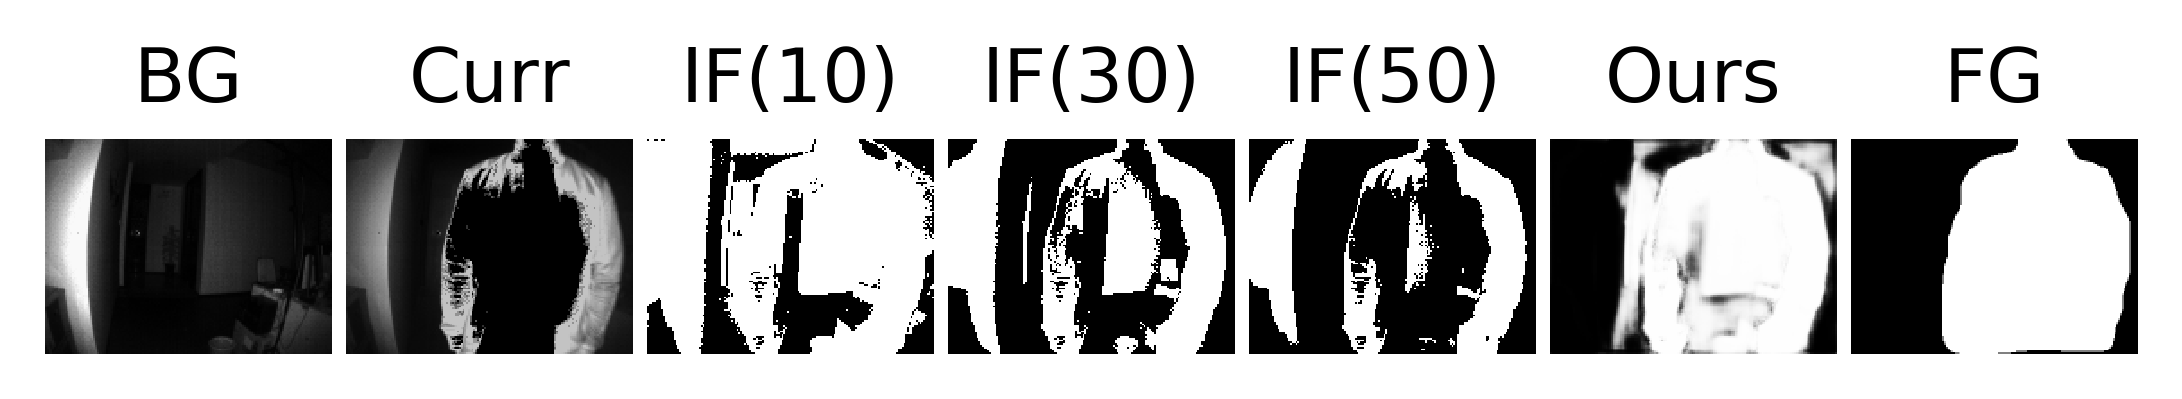

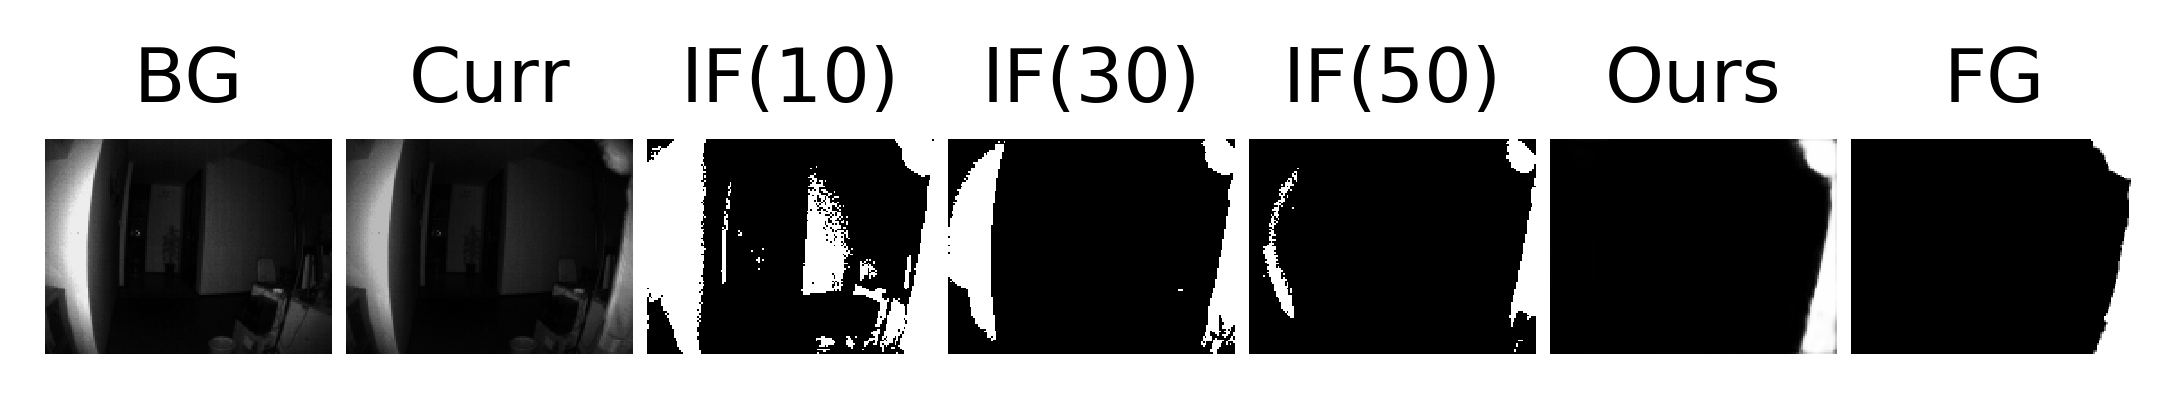

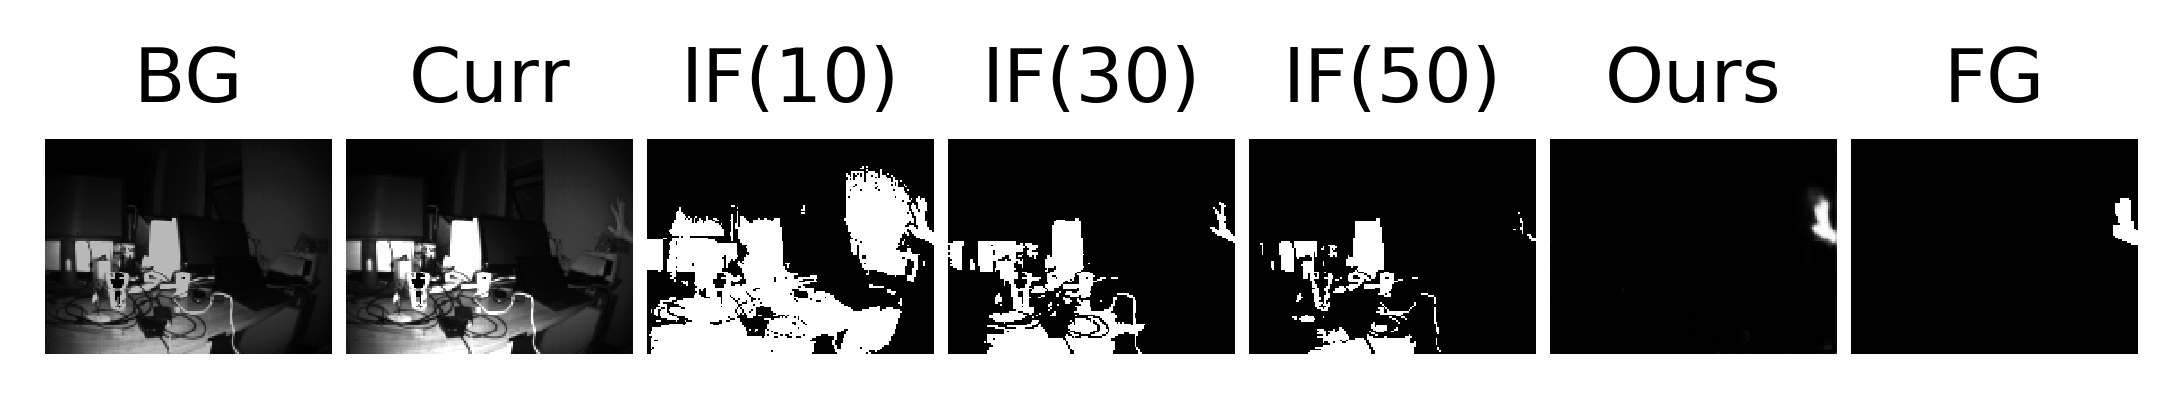

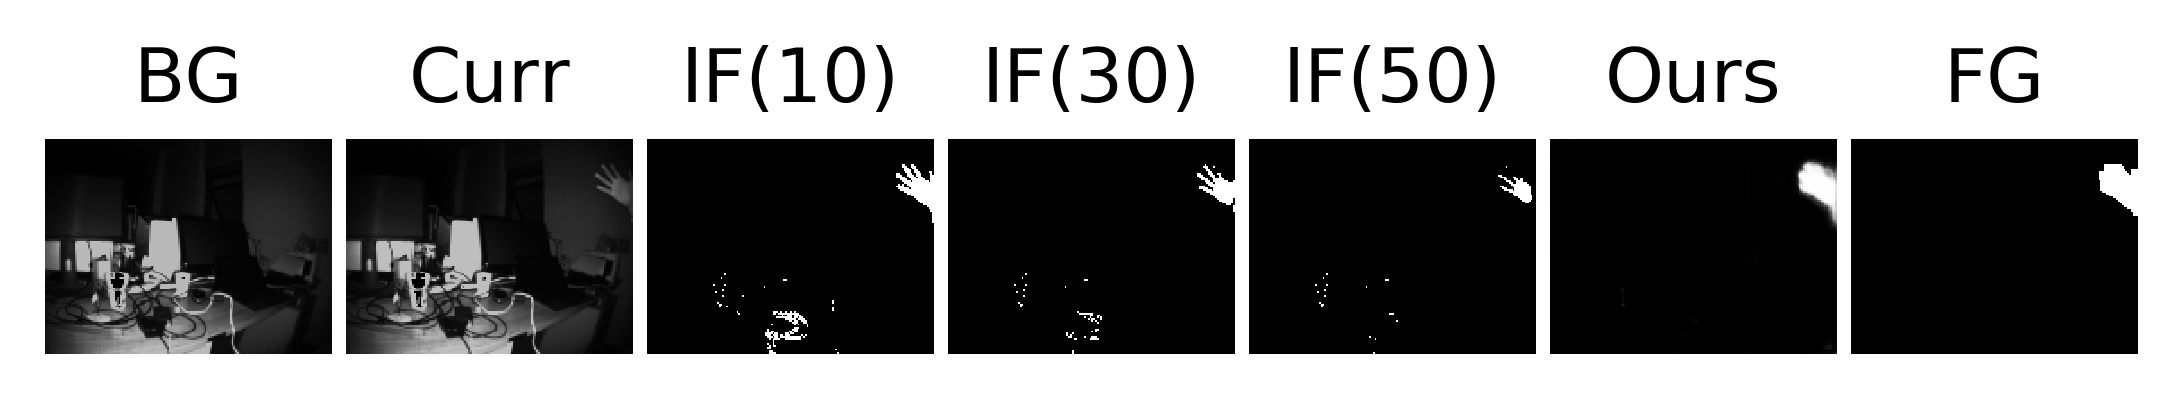

In [30]:
model_compiled.evaluate(test_ds_format)

for x, y_true in iter_slice(test_ds_format, 4):
    x, y_true = x.numpy(), y_true.numpy()
    # x = aug_2d_guass(x).numpy()
    y_pred = model_compiled.predict(x)
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]
    
    # Compare with inter-frame differencing
    y_diff_10 = np.where(np.abs(x[:,:,:,0] - x[:,:,:,1]) >= 10 / 255, 1., 0.).astype(np.float32) # inter-frame differencing (thresold = 10)
    y_diff_30 = np.where(np.abs(x[:,:,:,0] - x[:,:,:,1]) >= 30 / 255, 1., 0.).astype(np.float32) # inter-frame differencing (thresold = 20)
    y_diff_50 = np.where(np.abs(x[:,:,:,0] - x[:,:,:,1]) >= 50 / 255, 1., 0.).astype(np.float32) # inter-frame differencing (thresold = 30)
    

    imgs_visualization((x[0,:,:,0], x[0,:,:,1], y_diff_10[0], y_diff_30[0], y_diff_50[0], y_pred[0], y_true[0]),
                      ["BG", "Curr", "IF(10)", "IF(30)", "IF(50)", "Ours", "FG"])

# Deploy (OpenCV + TensorFlow Lite)

In [38]:
# Pruning

import tensorflow_model_optimization as tfmot
import tempfile

def get_gzipped_model_size(model):
    # return the size of model (Bytes)
    import os
    import zipfile
    _, keras_file = tempfile.mkstemp('.h5')
    model.save(keras_file, include_optimizer=False)
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)
    return os.path.getsize(zipped_file)

def model_optimize(model_compiled):
    # pruning
    optimizing_epochs = 10
    training_steps = train_ds_steps
    optimizing_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00, final_sparsity=0.30, begin_step=0, end_step=training_steps * optimizing_epochs)
    }
    model_for_optimizing = tfmot.sparsity.keras.prune_low_magnitude(model_compiled, **optimizing_params)
    optimizing_callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep()
    ]
    model_for_optimizing = compile_model(model_for_optimizing)
    model_for_optimizing.fit(train_ds_format, callbacks=optimizing_callbacks, epochs=optimizing_epochs, verbose=1, validation_data=valid_ds_format)
    model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_optimizing)
    model_for_export = compile_model(model_for_export)
    print("Size before pruning: ", get_gzipped_model_size(model_for_optimizing))
    print("Size after pruning: ", get_gzipped_model_size(model_for_export))
    return model_for_export

model_for_export = model_optimize(model_compiled)
model_for_export.evaluate(valid_ds_format)
model_for_export.evaluate(test_ds_format)

Instructions for updating:
Please use `layer.add_weight` method instead.
Epoch 1/10
28/28 [==============================] - 6s 221ms/step - loss: 0.0468 - metric_mIOU: 0.8075 - val_loss: 0.8056 - val_metric_mIOU: 0.2994
Epoch 2/10
28/28 [==============================] - 6s 217ms/step - loss: 0.0384 - metric_mIOU: 0.7995 - val_loss: 0.0806 - val_metric_mIOU: 0.7907
Epoch 3/10
28/28 [==============================] - 6s 215ms/step - loss: 0.0384 - metric_mIOU: 0.8201 - val_loss: 0.0669 - val_metric_mIOU: 0.8097
Epoch 4/10
28/28 [==============================] - 6s 229ms/step - loss: 0.0438 - metric_mIOU: 0.8061 - val_loss: 0.0866 - val_metric_mIOU: 0.7969
Epoch 5/10
28/28 [==============================] - 6s 206ms/step - loss: 0.0431 - metric_mIOU: 0.7989 - val_loss: 0.1029 - val_metric_mIOU: 0.7458
Epoch 6/10
28/28 [==============================] - 6s 210ms/step - loss: 0.0383 - metric_mIOU: 0.8310 - val_loss: 0.0819 - val_metric_mIOU: 0.8099
Epoch 7/10
28/28 [=====================

[0.04374154284596443, 0.8229466080665588]

In [41]:
# Save Model to *.pd

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tempfile

def model_save_pd(model_for_export):
    # model hdf5
    model_temp_path = tempfile.NamedTemporaryFile().name + '.hdf5'
    model_for_export.save(model_temp_path, include_optimizer=False)
    model_for_export = models.load_model(model_temp_path)
    flatten_input=tf.TensorSpec(shape=model_for_export.input_shape, dtype=tf.float32)
    f = tf.function(model_for_export).get_concrete_function(flatten_input)
    f2 = convert_variables_to_constants_v2(f)
    graph_def = f2.graph.as_graph_def()
    with tf.io.gfile.GFile(MODEL_PD_PATH, 'wb') as f:
        f.write(graph_def.SerializeToString())
    print('Saved')
    
model_save_pd(model_for_export)

Saved


In [42]:
# Save Model to *.tflite

import tensorflow as tf

def model_save_tflite(model_for_export):
    converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    open(MODEL_TFLITE_PATH, "wb").write(tflite_model)
    print('Saved')
    
model_save_tflite(model_for_export)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\chend\AppData\Local\Temp\tmpr_v3t9a5\assets
Saved


Model Loaded


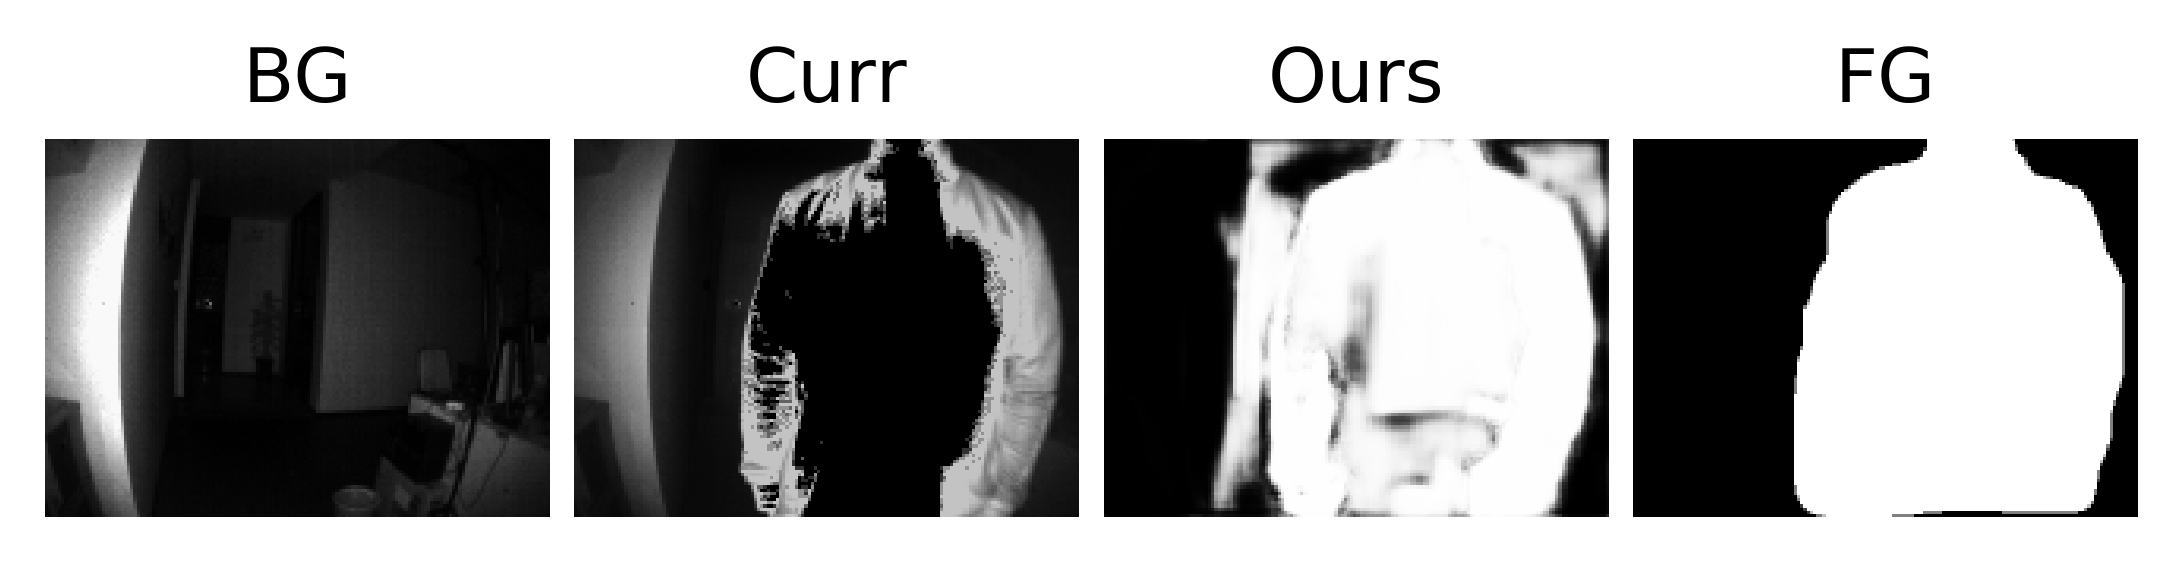

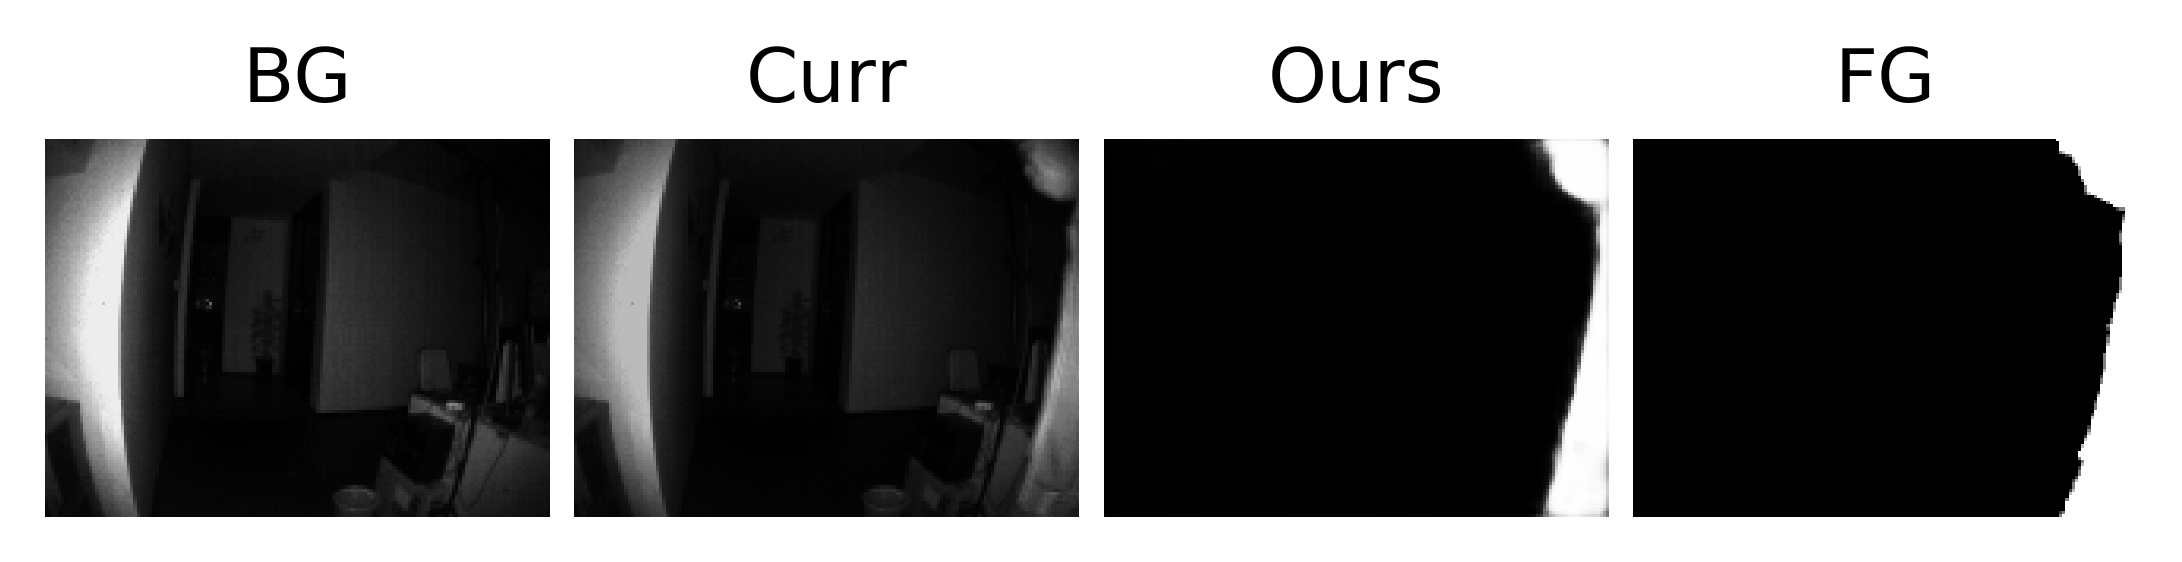

In [43]:
#Test with OpenCV

import numpy as np
import cv2 as cv

class model_opencv():
    def __init__(self, model_path):
        self.model_cv = cv.dnn.readNetFromTensorflow(model_path)
        print("Model Loaded")

    def predict(self, inputs):
        self.model_cv.setInput(np.transpose(inputs, (0, 3, 1, 2)))
        return np.transpose(self.model_cv.forward(), (0, 2, 3, 1))
        
model_cv = model_opencv(MODEL_PD_PATH)

for x, y_true in iter_slice(test_ds_format, 2):
    x, y_true = x.numpy(), y_true.numpy()
    y_pred = model_cv.predict(x)
    imgs_visualization((x[0,:,:,0], x[0,:,:,1], y_pred[0,:,:,0], y_true[0,:,:,0]), ["BG", "Curr", "Ours", "FG"])

Model Loaded


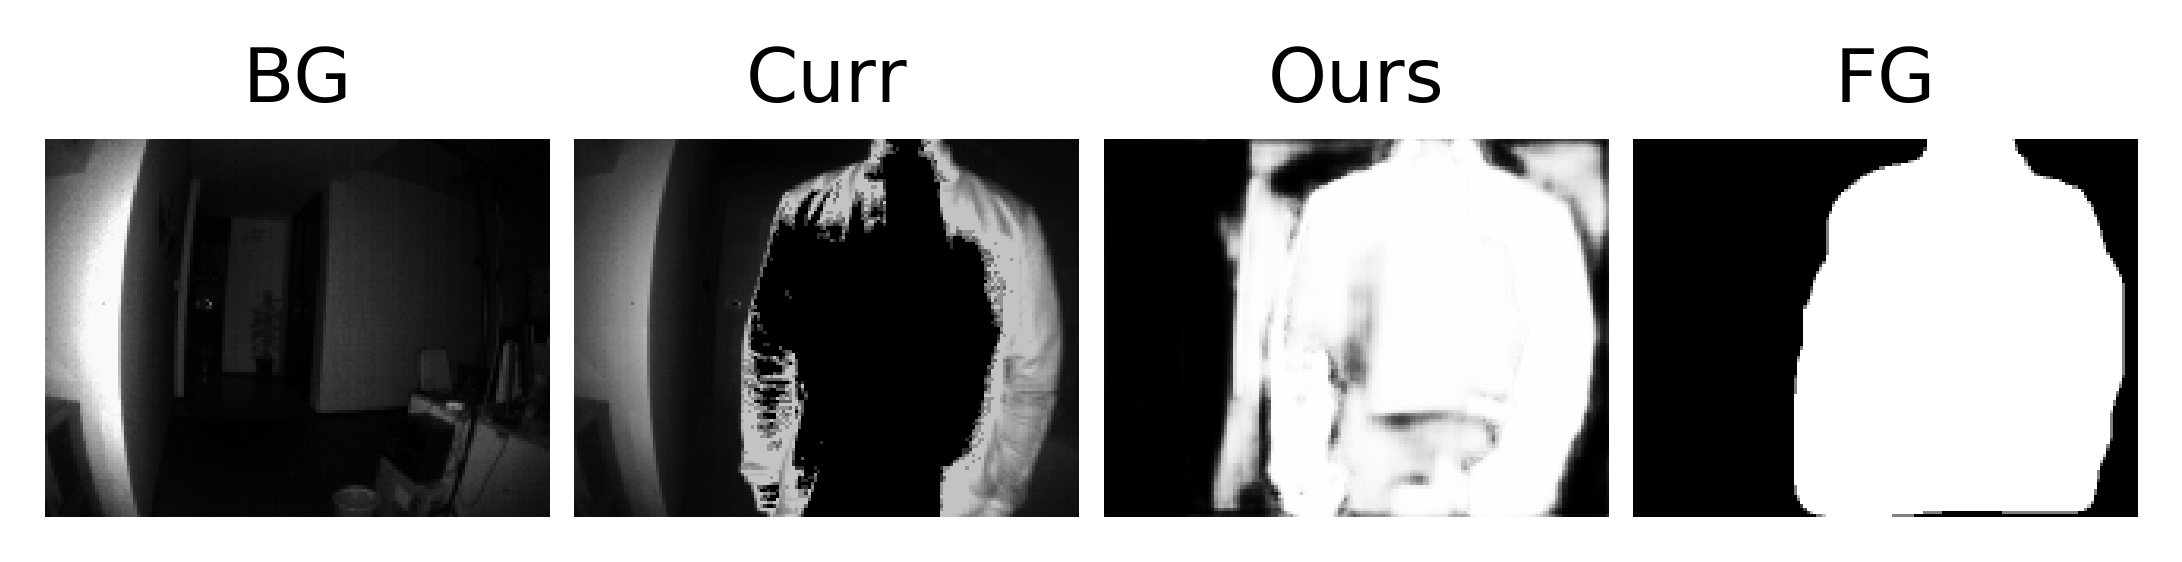

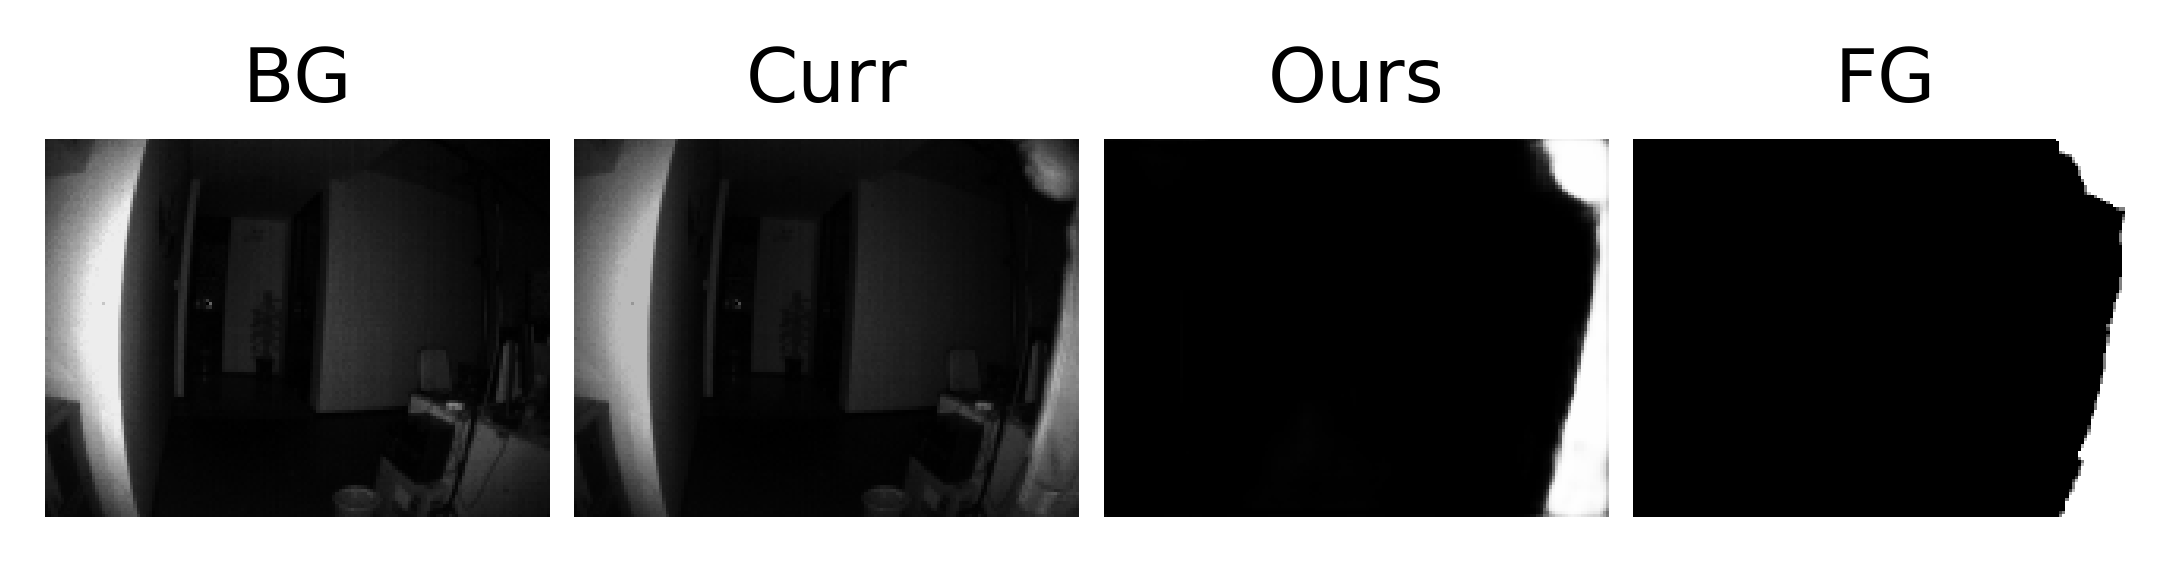

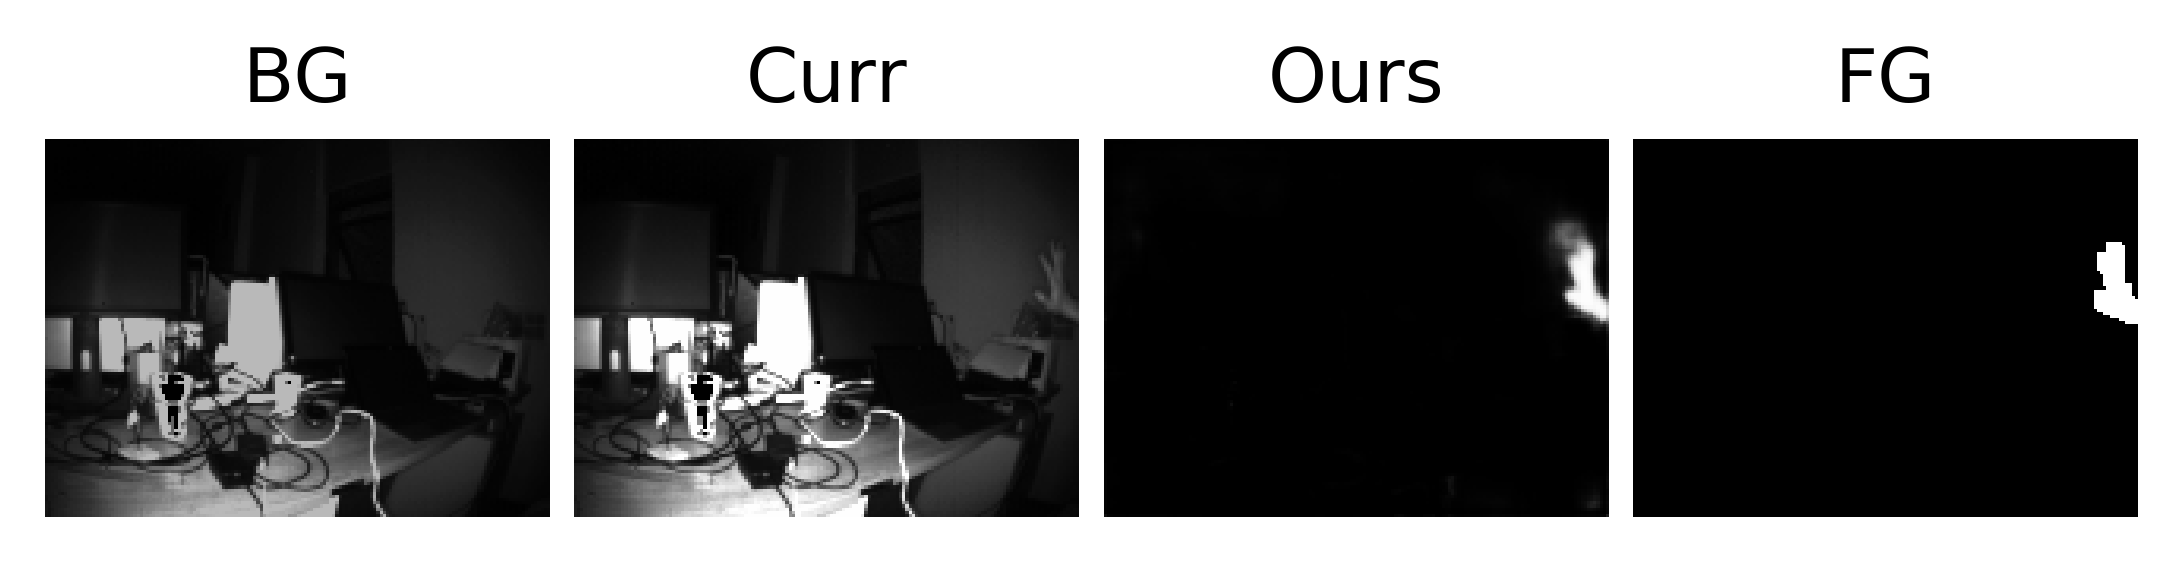

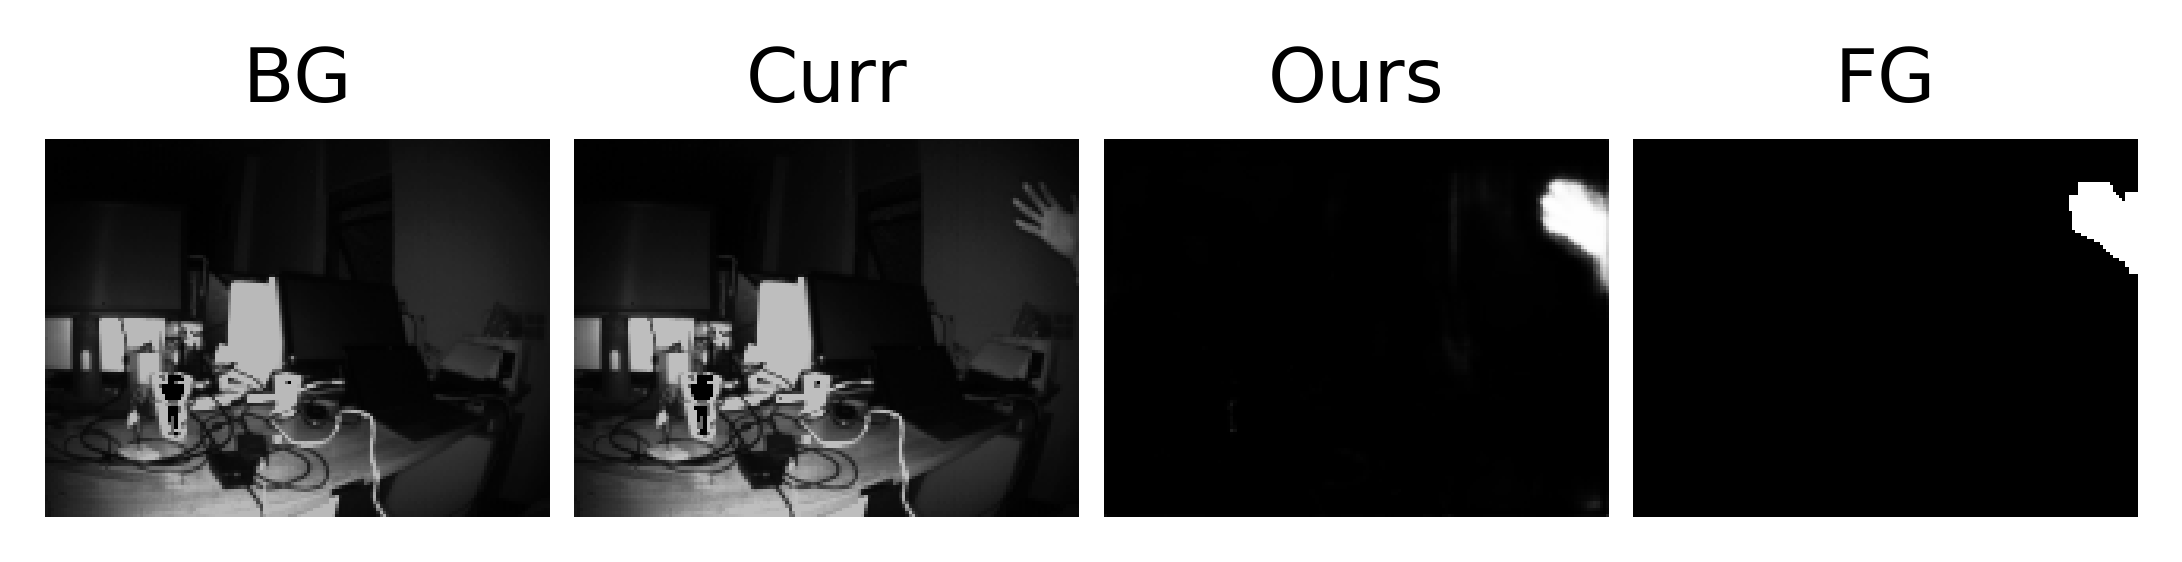

In [45]:
#Test with Tensorflow Lite

import numpy as np
import tensorflow as tf

class model_tflite():
    def __init__(self, model_path):
        # Load the TFLite model and allocate tensors.
        self.interpreter = tf.lite.Interpreter(model_path=model_path)

        # Get input and output tensors.
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
        input_shape = [BATCH_SIZE] + list(self.input_details[0]['shape'][1:])
        self.interpreter.resize_tensor_input(self.input_details[0]['index'], input_shape)
        self.interpreter.allocate_tensors()
        print("Model Loaded")

    def predict(self, inputs):
        self.interpreter.set_tensor(self.input_details[0]['index'], 
                                   np.pad(inputs, ((0, BATCH_SIZE - inputs.shape[0]), (0, 0), (0, 0), (0, 0))))
        self.interpreter.invoke()
        return self.interpreter.get_tensor(self.output_details[0]['index'])[:inputs.shape[0]]

model_tflite = model_tflite(MODEL_TFLITE_PATH)

for x, y_true in iter_slice(test_ds_format, 4):
    x, y_true = x.numpy(), y_true.numpy()
    y_pred = model_tflite.predict(x)
    imgs_visualization((x[0,:,:,0], x[0,:,:,1], y_pred[0,:,:,0], y_true[0,:,:,0]), ["BG", "Curr", "Ours", "FG"])